# Elo Merchant

## Introduction
This notebook represents Sean Ng's submission to elo merchant. 

I got some feature engineering ideas from:

In [1]:
#Declaring imports
import csv
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgd


/anaconda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [107]:
EXPLORE = False

In [95]:
#Files
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'
history_path = '../input/historical_transactions.csv'
merchant_path = '../input/merchants.csv'
new_transactions_path = '../input/new_merchant_transactions.csv'


In [213]:
train_df = pd.read_csv(train_data_path, parse_dates=["first_active_month"])
test_df = pd.read_csv(test_data_path, parse_dates=["first_active_month"])
n_train = train_df.shape[0]


In [5]:
history_df = pd.read_csv(history_path, parse_dates=["purchase_date"])

In [6]:
merchants = pd.read_csv(merchant_path)

In [7]:
new_transactions_df = pd.read_csv(new_transactions_path, parse_dates=["purchase_date"])

In [97]:
all_data = train_df.append(test_df, ignore_index=True)

/anaconda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [46]:
all_transactions = history_df.append(new_transactions_df, ignore_index=True)

In [47]:
all_data.describe()

,feature_1,feature_2,feature_3,target
count,325540.00000,325540.000000,325540.000000,201917.000000
mean,3.10681,1.744038,0.565116,-0.393636
std,1.18728,0.750540,0.495742,3.850500
min,1.00000,1.000000,0.000000,-33.219281
25%,2.00000,1.000000,0.000000,-0.883110
50%,3.00000,2.000000,1.000000,-0.023437
75%,4.00000,2.000000,1.000000,0.765453
max,5.00000,3.000000,1.000000,17.965068


In [48]:
all_transactions.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,3.107539e+07,2.831078e+07,3.107539e+07,3.107539e+07
mean,1.296453e+02,6.506728e-01,4.778518e+02,-4.110560e+00,-7.032267e-04,2.194792e+00,1.058662e+01,2.679329e+01
std,1.040926e+02,2.734985e+00,2.494821e+02,3.766495e+00,1.087456e+03,1.531650e+00,6.347145e+00,9.723248e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.300000e+01,0.000000e+00,3.020000e+02,-7.000000e+00,-7.199051e-01,1.000000e+00,9.000000e+00,1.900000e+01
50%,9.000000e+01,0.000000e+00,4.540000e+02,-3.000000e+00,-6.875230e-01,1.000000e+00,9.000000e+00,2.900000e+01
75%,2.120000e+02,1.000000e+00,7.050000e+02,-1.000000e+00,-6.008651e-01,3.000000e+00,1.600000e+01,3.400000e+01
max,3.470000e+02,9.990000e+02,8.910000e+02,2.000000e+00,6.010604e+06,5.000000e+00,2.400000e+01,4.100000e+01


In [52]:
print("All data shape:" + str(all_data.shape))
print("-----------------------------------------------------")
print("Train data shape:" + str(train_df.shape))
print("Test data shape:" + str(test_df.shape))
print("=====================================================")
print("All transactions data shape:" + str(all_transactions.shape))
print("-----------------------------------------------------")
print("Old transactions data shape:" + str(history_df.shape))
print("New transactions data shape:" + str(new_transactions_df.shape))

All data shape:(325540, 6)
-----------------------------------------------------
Train data shape:(201917, 6)
Test data shape:(123623, 5)
All transactions data shape:(31075392, 14)
-----------------------------------------------------
Old transactions data shape:(29112361, 14)
New transactions data shape:(1963031, 14)


In [50]:
def get_df_name(df):
    for x in globals():
        if globals()[x] is df:
            return x

In [204]:
#Finding number of null values
def count_nulls(df_list):
    result = {}
    for df in df_list:
        vals = {}
        for key in df.keys():
            count = df[key].isnull().sum()
            if count > 0:
                vals[key] = count
        name = get_df_name(df)
        result[name] = vals
    return pd.DataFrame.from_dict(result, dtype=int)
count_nulls([all_data, all_transactions, merchants])


,all_data,all_transactions,merchants
avg_sales_lag12,NaN,NaN,13.0
avg_sales_lag3,NaN,NaN,13.0
avg_sales_lag6,NaN,NaN,13.0
category_2,NaN,NaN,11887.0
first_active_month,1.0,NaN,NaN
merchant_id,NaN,164697.0,NaN
target,123623.0,NaN,NaN


# Handling Nulls

1. Viewing the distribution of non-null values

In [18]:
#putting each col into a bucket
def classify_categories(df, cols):
    discrete = []
    continuous = []
    for col in cols:
        
        length = len(df[col].unique())
        if length <= 25 :
            discrete.append(col)
        else:
            continuous.append(col)
    return discrete, continuous


In [19]:
def plot_na(df, cols):
    discrete, continuous = classify_categories(df, cols)
    all_count = len(continuous) + len(discrete)
    #Distributions of continuous dVata
    fig, axes = plt.subplots(nrows=all_count, ncols=1, figsize=(3,5*all_count))
    if all_count == 1:
        axes = [axes]
    for i, col_name in enumerate(discrete):
        df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)
    for i, col_name in enumerate(continuous):
        df[col_name].plot(kind='density', ax=axes[i+len(discrete)], title = col_name)
    


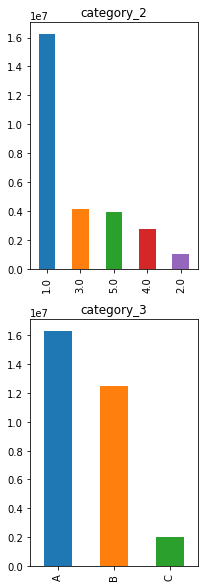

In [20]:
if EXPLORE:
    plot_na(all_transactions, ["category_2", "category_3"])

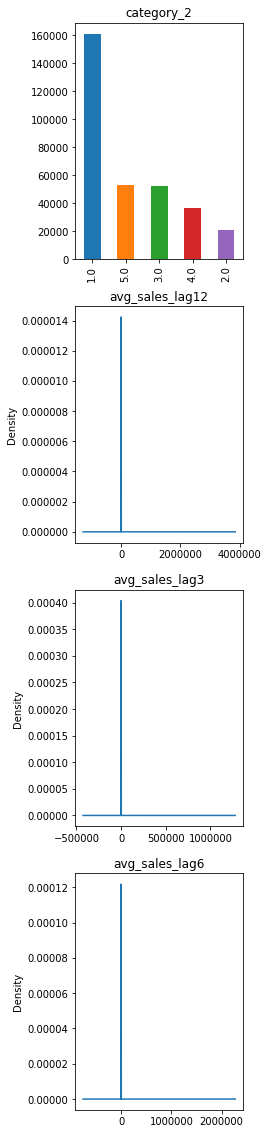

In [21]:
if EXPLORE:
    plot_na(merchants, ['avg_sales_lag12','avg_sales_lag3','avg_sales_lag6','category_2'])

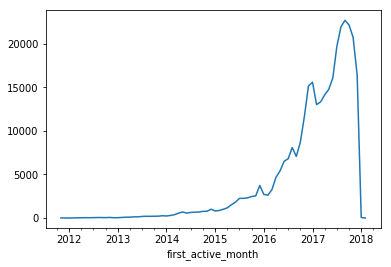

In [22]:
if EXPLORE:
    #Plot date to get a rough idea
    all_data.set_index(['first_active_month']).groupby('first_active_month').card_id.count().plot()

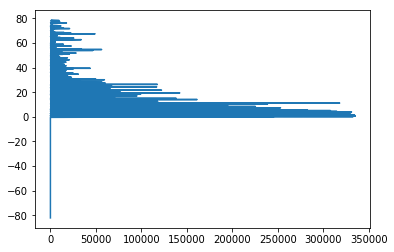

In [23]:
if EXPLORE:
    merchants.avg_sales_lag3[merchants.avg_sales_lag3!=np.nan].sort_values(ascending=False)[500:].plot()

# Feature Engineering

## Converting date to corresponding date difference

In [98]:
from datetime import datetime
from dateutil import relativedelta
def convert_date_to_timediff(df, cols):
    new_df = df.copy()
    today = datetime.today()
    for col in cols:
        diff = df[col].dropna().map(lambda x: relativedelta.relativedelta(today,x))
        diff = diff.map(lambda x: x.years * 12 + x.months).astype('int64')
        new_df[col] = diff
    return new_df

dtype('float64')

In [99]:
all_data = convert_date_to_timediff(all_data, ["first_active_month"])

In [103]:
all_transactions = convert_date_to_timediff(all_transactions, ["purchase_date"])

## LabelEncode/ Hot Encode the necessary values


In [143]:
from sklearn.preprocessing import LabelEncoder
def LabelEncodeCols(df, cols):
    new_df = df.copy()
    for col in cols:
        lbl = LabelEncoder()
        new_df[col] = lbl.fit_transform(new_df[col])
    return new_df



In [150]:
all_transactions = LabelEncodeCols(all_transactions, ["authorized_flag", "category_1"])

In [162]:
all_transactions = pd.get_dummies(all_transactions, columns=["category_2", "category_3"])

In [203]:
all_transactions.keys()

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount',
       'purchase_date', 'state_id', 'subsector_id', 'category_2_1.0',
       'category_2_2.0', 'category_2_3.0', 'category_2_4.0', 'category_2_5.0',
       'category_3_A', 'category_3_B', 'category_3_C'],
      dtype='object')

In [194]:
#TODO: Consider if I should flag out data that is not authoized (authorized flag)
def aggregate_transactions(history):
    
    agg = {
        "authorized_flag":["mean"],
        "category_1":["mean"],
        "category_2_1.0":["mean"], 
        "category_2_2.0":["mean"],
        "category_2_3.0":["mean"],
        "category_2_4.0":["mean"],
        "category_2_5.0":["mean"],
        "category_3_A":["mean"],
        "category_3_B":["mean"],
        "category_3_C":["mean"],
        "city_id":['nunique'],
        "merchant_id":['nunique'],
        "state_id":['nunique'],
        "subsector_id":["nunique"],
        "purchase_amount":["mean", "std", np.ptp],
    }
    
    new_df = history.groupby("card_id").agg(agg)
    #Replace columns
    new_df.columns = [' '.join(col).strip() for col in new_df.columns.values]
    return new_df
    

In [196]:
aggregate_transactions = aggregate_transactions(all_transactions)

In [201]:
all_data = pd.merge(all_data, aggregate_transactions, on='card_id', how='left')

In [205]:
#Consider adding other columns. i.e. grouping the values across time (!!!!!)

In [200]:
#tuning hyperparameters

In [171]:
#Features that others added
#Handling month_lag?

1. Month difference between today and purchase date (might be more significant than just date(?). I need to be able to convert to something significant anyway
2. Aggregation based statistics


# Training Phase

In [233]:
target = all_data["target"][:n_train]
to_be_deleted = ["target", "card_id"]
for col in to_be_deleted:
    if col in all_data.keys():
        del all_data[col]
train = all_data[:n_train]
test = all_data[n_train:]

In [224]:
# Selecting the right features
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [235]:
import time
from sklearn.model_selection import KFold
import lightgbm as lgb
categorical_feats = ["feature_2", "feature_3"]
folds = KFold(n_splits = 5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
features = all_data.keys()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/anaconda/envs/tensorflow/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda/envs/tensorflow/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.81561	valid_1's rmse: 3.86943
[200]	training's rmse: 3.79775	valid_1's rmse: 3.86284
[300]	training's rmse: 3.78388	valid_1's rmse: 3.85984
[400]	training's rmse: 3.77257	valid_1's rmse: 3.85805
[500]	training's rmse: 3.76348	valid_1's rmse: 3.8574
[600]	training's rmse: 3.75556	valid_1's rmse: 3.85702
[700]	training's rmse: 3.74873	valid_1's rmse: 3.85699
[800]	training's rmse: 3.74288	valid_1's rmse: 3.85708
Early stopping, best iteration is:
[647]	training's rmse: 3.75216	valid_1's rmse: 3.8569
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.83532	valid_1's rmse: 3.79192
[200]	training's rmse: 3.81737	valid_1's rmse: 3.78597
[300]	training's rmse: 3.80361	valid_1's rmse: 3.78287
[400]	training's rmse: 3.79249	valid_1's rmse: 3.78148
[500]	training's rmse: 3.78389	valid_1's rmse: 3.78106
[600]	training's rmse: 3.77626	valid_1's rmse: 3.78077
[700]	t

NameError: name 'mean_squared_error' is not defined

In [228]:
all_data

,card_id,feature_1,feature_2,feature_3,first_active_month,authorized_flag mean,category_1 mean,category_2_1.0 mean,category_2_2.0 mean,category_2_3.0 mean,...,category_3_A mean,category_3_B mean,category_3_C mean,city_id nunique,merchant_id nunique,state_id nunique,subsector_id nunique,purchase_amount mean,purchase_amount std,purchase_amount ptp
0,C_ID_92a2005557,5,2,1,18.0,0.954064,0.000000,0.989399,0.000000,0.000000,...,0.985866,0.014134,0.000000,9,117,3,21,-0.633261,0.207520,2.997789
1,C_ID_3d0044924f,4,1,0,23.0,0.969101,0.087079,0.912921,0.000000,0.000000,...,0.000000,0.792135,0.202247,9,148,3,24,-0.602141,0.382049,5.372699
2,C_ID_d639edf6cd,2,2,0,28.0,0.954545,0.000000,0.090909,0.000000,0.000000,...,1.000000,0.000000,0.000000,5,14,2,8,-0.678812,0.086422,0.584291
3,C_ID_186d6a6901,4,3,0,15.0,1.000000,0.154762,0.142857,0.000000,0.000000,...,0.000000,0.880952,0.083333,7,57,5,15,-0.644592,0.251051,2.186493
4,C_ID_cdbd2c0db2,1,3,0,13.0,0.970414,0.100592,0.071006,0.000000,0.041420,...,0.000000,0.946746,0.047337,7,102,7,19,-0.405999,1.205310,7.939197
5,C_ID_0894217f2f,4,2,0,27.0,0.972973,0.027027,0.945946,0.000000,0.000000,...,0.000000,0.243243,0.756757,4,26,3,10,-0.410170,0.190859,0.713008
6,C_ID_7e63323c00,3,2,1,24.0,0.935849,0.000000,0.003774,0.000000,0.000000,...,1.000000,0.000000,0.000000,6,68,4,13,-0.713299,0.030118,0.191408
7,C_ID_dfa21fc124,3,2,1,15.0,0.880000,0.000000,0.280000,0.000000,0.000000,...,1.000000,0.000000,0.000000,3,12,2,7,-0.626566,0.172267,0.689717
8,C_ID_fe0fdac8ea,2,1,0,16.0,0.764706,0.235294,0.764706,0.000000,0.000000,...,0.000000,0.941176,0.058824,2,10,2,6,-0.586561,0.152323,0.494733
9,C_ID_bf62c0b49d,2,2,0,28.0,0.879310,0.000000,0.991379,0.000000,0.000000,...,0.974138,0.025862,0.000000,6,62,3,13,-0.682220,0.083797,0.371966
